## Getting data

檢視圖片

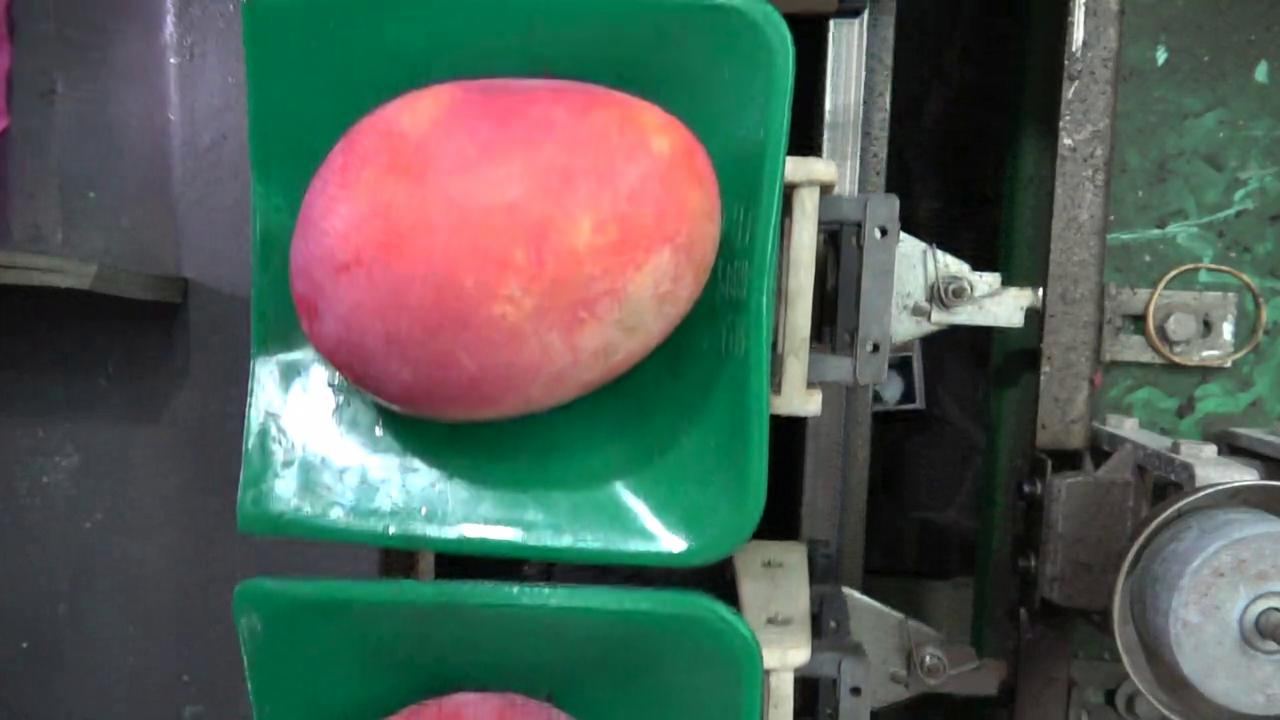

In [1]:
from PIL import Image
image = Image.open(r'.\C2_TrainDev\Train\03182.jpg')
image

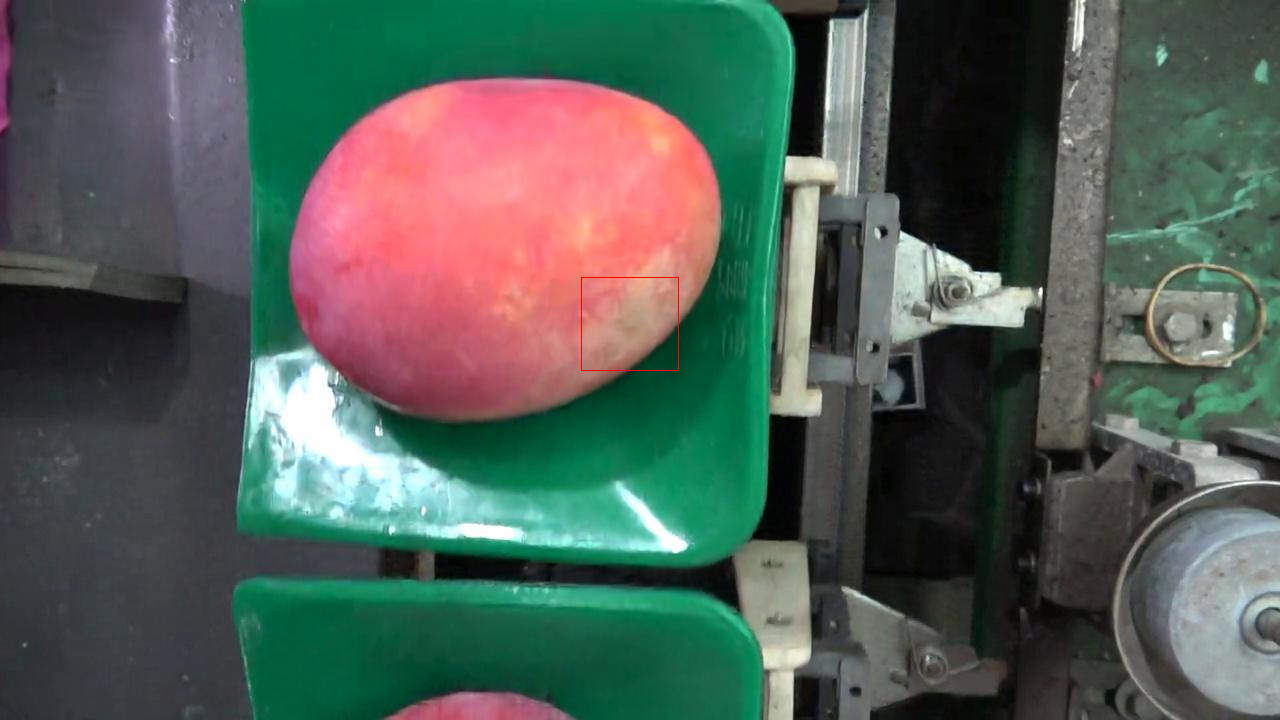

In [2]:
from PIL import ImageDraw
xmin = 581
ymin = 277
xmax = xmin+97
ymax = ymin+93
draw = ImageDraw.Draw(image)
draw.rectangle([(xmin, ymin), (xmax, ymax)], outline ="red")
image

Original image size: 1280 x 720
Modify image size: 640 x 360


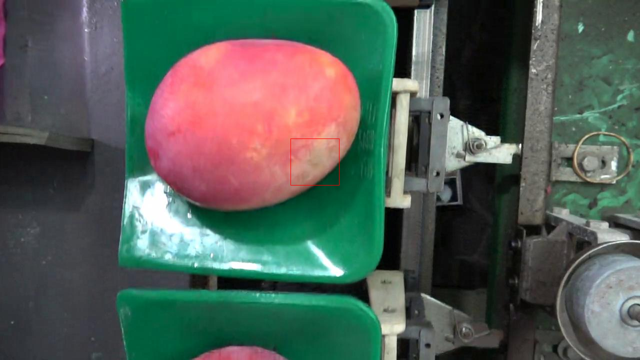

In [13]:
width, height = image.size
print('Original image size:',width,'x',height)

factor = 0.5
image_sized = image.resize((round(width*factor),round(height*factor)))
width, height = image_sized.size
print('Modify image size:',width,'x',height)
image_sized   

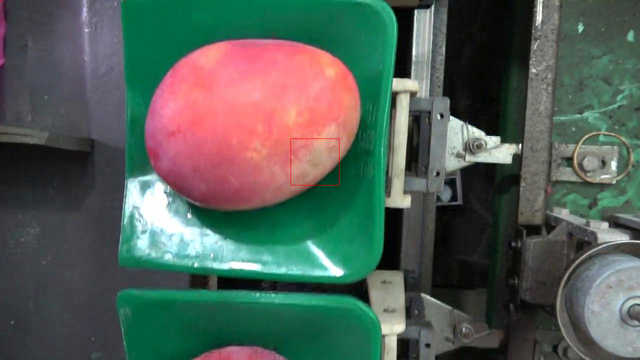

In [14]:
xmin = round(xmin*factor)
ymin = round(ymin*factor)
xmax = round(xmax*factor)
ymax = round(ymax*factor)

draw = ImageDraw.Draw(image_sized)
draw.rectangle([(xmin, ymin), (xmax, ymax)], outline ="red")
image_sized

Inspect data

In [ ]:
import pandas as pd
df = pd.read_csv(r".\C2_TrainDev\train.csv", header=None)
df

In [ ]:
import numpy as np
label=[]
image=[]
xmin=[]
ymin=[]
xmax=[]
ymax=[]

with open(r'.\C2_TrainDev\train.csv', 'r', encoding='utf-8-sig') as fh:
  for index,row in enumerate(fh):
    row=row.strip()
    row=row.split(',')
    while True:
      if '' in row:
        row.remove('')
      else:
        break

    while len(row) > 1:
      xmin.append(float(row[1]))
      ymin.append(float(row[2]))
      xmax.append(float(row[3])+float(row[1]))
      ymax.append(float(row[4])+float(row[2]))
      label.append(row[5])
      for idx in range(5):
        row.remove(row[1]) 
      image.append(row[0])

print('label:' ,len(label))
print('image:' ,len(image))
print('xmin:' ,len(xmin))
print('ymin:' ,len(ymin))
print('xmax:' ,len(xmax))
print('ymax:' ,len(ymax))


In [ ]:
traindf = pd.DataFrame({'image':image, 'label':label, 'xmin':xmin, 'ymin':ymin, 'xmax':xmax, 'ymax':ymax  })
#traindf.to_pickle(r".\C2_TrainDev\traindf.pkl")
traindf

In [ ]:
import numpy as np
label=[]
image=[]
xmin=[]
ymin=[]
xmax=[]
ymax=[]

with open(r'.\C2_TrainDev\dev.csv', 'r', encoding='utf-8-sig') as fh:
  for index,row in enumerate(fh):
    row=row.strip()
    row=row.split(',')
    while True:
      if '' in row:
        row.remove('')
      else:
        break

    while len(row) > 1:
      xmin.append(float(row[1]))
      ymin.append(float(row[2]))
      xmax.append(float(row[3])+float(row[1]))
      ymax.append(float(row[4])+float(row[2]))
      label.append(row[5])
      for idx in range(5):
        row.remove(row[1]) 
      image.append(row[0])

print('label:' ,len(label))
print('image:' ,len(image))
print('xmin:' ,len(xmin))
print('ymin:' ,len(ymin))
print('xmax:' ,len(xmax))
print('ymax:' ,len(ymax))


In [ ]:
validdf = pd.DataFrame({'image':image, 'label':label, 'xmin':xmin, 'ymin':ymin, 'xmax':xmax, 'ymax':ymax  })
#validdf.to_pickle(r".\C2_TrainDev\validdf.pkl")
validdf

## Pytorch

### installation

In [ ]:
cd .\pytorch_object_detection\vision\references\detection

In [ ]:
import pycocotools
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import pandas as pd
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision
from engine import train_one_epoch, evaluate
import utils
import transforms as T
import os

### Configuring the model

#### 1. Preparing the data

In [ ]:
def parse_one_annot(image, train_state=True):
  if train_state:
    boxes_array = traindf[traindf["image"] == image][["xmin", "ymin", "xmax", "ymax"]].values
  else:
    boxes_array = validdf[validdf["image"] == image][["xmin", "ymin", "xmax", "ymax"]].values
  return boxes_array

##### training set

In [ ]:
class TrainDataset(torch.utils.data.Dataset):
  def __init__(self, root, transforms=None):
    self.root = root
    self.transforms = transforms
    self.imgs = sorted(os.listdir(os.path.join(root, "Train")))

  def __getitem__(self, idx):
    # load images and bounding boxes
    img_path = os.path.join(self.root, "Train", self.imgs[idx])
    img = Image.open(img_path).convert("RGB")
    
    #----------------------------------------
    (width, height) = img.size
    factor = 0.1
    img = img.resize((round(width*factor),round(height*factor)))
    #----------------------------------------
    
    box_list = parse_one_annot(self.imgs[idx], True)
    
    #----------------------------------------
    boxes = torch.round(torch.as_tensor(box_list, dtype=torch.float32) * factor)
    #----------------------------------------
    
    num_objs = len(box_list)
    
    # there is only one class******************************************************
    labels = torch.ones((num_objs,), dtype=torch.int64)
    for row in range(len(traindf[traindf['image'] == self.imgs[idx]])):
      if traindf[traindf['image'] == self.imgs[idx]]['label'].iloc[row] == '不良-乳汁吸附':
        labels[row] = 1
      elif traindf[traindf['image'] == self.imgs[idx]]['label'].iloc[row] == '不良-機械傷害':
        labels[row] = 2
      elif traindf[traindf['image'] == self.imgs[idx]]['label'].iloc[row] == '不良-炭疽病': 
        labels[row] = 3
      elif traindf[traindf['image'] == self.imgs[idx]]['label'].iloc[row] == '不良-著色不佳':
        labels[row] = 4
      else:
        labels[row] = 5
      
    image_id = torch.tensor([idx])
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,0])

    # suppose all instances are not crowd
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd
    if self.transforms is not None:
      img, target = self.transforms(img, target)
    return img, target

  def __len__(self):
    return len(self.imgs)

In [ ]:
train_set = TrainDataset(root= r".\..\..\..\..\C2_TrainDev")
train_set[-1]

##### valid set

In [ ]:
class ValidDataset(torch.utils.data.Dataset):
  def __init__(self, root, transforms=None):
    self.root = root
    self.transforms = transforms
    self.imgs = sorted(os.listdir(os.path.join(root, "Dev")))

  def __getitem__(self, idx):
    # load images and bounding boxes
    img_path = os.path.join(self.root, "Dev", self.imgs[idx])
    img = Image.open(img_path).convert("RGB")
    
    #---------------------------------------
    (width, height) = img.size 
    factor = 0.1
    img = img.resize((round(width*factor),round(height*factor)))
    #----------------------------------------
    
    box_list = parse_one_annot(self.imgs[idx], False)
    
    #---------------------------------------
    boxes = torch.round(torch.as_tensor(box_list, dtype=torch.float32) * factor)
    #---------------------------------------
    
    num_objs = len(box_list)

    # there is only one class******************************************************
    labels = torch.ones((num_objs,), dtype=torch.int64)
    for row in range(len(validdf[validdf['image'] == self.imgs[idx]])):
      if validdf[validdf['image'] == self.imgs[idx]]['label'].iloc[row] == '不良-乳汁吸附':
        labels[row] = 1
      elif validdf[validdf['image'] == self.imgs[idx]]['label'].iloc[row] == '不良-機械傷害':
        labels[row] = 2
      elif validdf[validdf['image'] == self.imgs[idx]]['label'].iloc[row] == '不良-炭疽病': 
        labels[row] = 3
      elif validdf[validdf['image'] == self.imgs[idx]]['label'].iloc[row] == '不良-著色不佳':
        labels[row] = 4
      else:
        labels[row] = 5
      
    image_id = torch.tensor([idx])
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,0])

    # suppose all instances are not crowd
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd
    if self.transforms is not None:
      img, target = self.transforms(img, target)
    return img, target

  def __len__(self):
    return len(self.imgs)

In [ ]:
valid_set = ValidDataset(root= r".\..\..\..\..\C2_TrainDev")
valid_set[-1]

In [ ]:
print('train: ', len(train_set))
print('valid: ', len(valid_set))

#### 2.Download and adjust the model

In [ ]:
def get_model(num_classes):
  # load an object detection model pre-trained on COCO
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  # get the number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new on
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)
   
  return model

In [ ]:
def get_transform(train):
   transforms = []
   # converts the image, a PIL image, into a PyTorch Tensor
   transforms.append(T.ToTensor())
   if train:
      # during training, randomly flip the training images
      # and ground-truth for data augmentation
      transforms.append(T.RandomHorizontalFlip(0.5))
   return T.Compose(transforms)

In [ ]:
# use our dataset and defined transformations
train_set = TrainDataset(root= r".\..\..\..\..\C2_TrainDev",\
              transforms = get_transform(train=True))

valid_set = ValidDataset(root= r".\..\..\..\..\C2_TrainDev",\
                transforms = get_transform(train=False))
# split the dataset in train and test set
torch.manual_seed(1)

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(train_set, batch_size=2, shuffle=True, collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(valid_set, batch_size=2, shuffle=False, collate_fn=utils.collate_fn)
print("We have: {} examples,  {} are training and {} testing".format(len(train_set)+len(valid_set) ,len(train_set), len(valid_set)))

### Making predictions with the model

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(torch.cuda.get_device_name())
# our dataset has two classes only - raccoon and not racoon****************************************
num_classes = 6
# get the model using our helper function
model = get_model(num_classes)
# move model to the right device
model.to(device)
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler which decreases the learning rate by # 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# 注意
<hr>
若要自行**訓練**，請將下列cell 取消comment。<br>
請確定目前VRAM有7G以上空間。<br>
本模型在Dev_set上需訓練22小時。<br>

**請確保執行期間程式不會中斷。**

In [ ]:
num_epochs = 1
for epoch in range(num_epochs):
   # train for one epoch, printing every 10 iterations
   train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
   # update the learning rate
   lr_scheduler.step()
   # evaluate on the test dataset
   evaluate(model, data_loader_test, device=device)

In [ ]:
remove_comment=\
'''
try:
    os.mkdir(r".\..\..\..\..\pytorch_object_detection\mango")
except:
    print('folder already exists')
    pass
torch.save(model.state_dict(), r".\..\..\..\..\pytorch_object_detection\mango\model")
'''

load in model

In [ ]:
#loaded_model = get_model(num_classes = 6)
#loaded_model.load_state_dict(torch.load(r".\..\..\..\..\pytorch_object_detection\mango\model", map_location=device))

result

In [ ]:
idx = 2
img, _ = valid_set[idx]
label_boxes = np.array(valid_set[idx][1]["boxes"])
#put the model in evaluation mode
loaded_model.eval()
with torch.no_grad():
   prediction = loaded_model([img])
image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
draw = ImageDraw.Draw(image)
# draw groundtruth
for elem in range(len(label_boxes)):
   draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
   (label_boxes[elem][2], label_boxes[elem][3])], 
   outline ="green", width =3)
for element in range(len(prediction[0]["boxes"])):
   boxes = prediction[0]["boxes"][element].cpu().numpy()
   score = np.round(prediction[0]["scores"][element].cpu().numpy(),
                    decimals= 4)
   if score > 0.5:
      draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
      outline ="red", width =3)
      draw.text((boxes[0], boxes[1]), text = str(score))
image

In [ ]:
prediction

# 注意
<hr>
預測完整個Dev資料匣需要耗費3小時<br>

**請確定執行過程不會中斷**

In [ ]:
root= r".\..\..\..\..\C2_TrainDev"
imgs = sorted(os.listdir(os.path.join(root, "Dev")))

In [ ]:
loaded_model.eval()
files=[]
#label_map = {'不良-乳汁吸附':1, '不良-機械傷害':2, '不良-炭疽病':3, '不良-著色不佳':4, '不良-黑斑病':5}
class1=[]
class2=[]
class3=[]
class4=[]
class5=[]

for i in tqdm(range(len(imgs)), position=0, leave=True):
    idx = i
    img, _ = valid_set[idx]
                                                  
    aa=bb=cc=dd=ee=0

    with torch.no_grad():
        prediction = loaded_model([img])    
                           
    for element in range(len(prediction[0]["scores"])):
        score = np.round(prediction[0]["scores"][element].numpy(), decimals= 4)
        
        if score > 0.5:
            if prediction[0]["labels"][element].numpy() == 1:
                aa=1
            elif prediction[0]["labels"][element].numpy() == 2:
                bb=1
            elif prediction[0]["labels"][element].numpy() == 3:
                cc=1
            elif prediction[0]["labels"][element].numpy() == 4:               
                dd=1
            elif prediction[0]["labels"][element].numpy() == 5:
                ee=1
        else:
            break
                           
    if aa == 1:
        class1.append(True)
    else:
        class1.append(False)

    if bb == 1:
        class2.append(True)
    else:
        class2.append(False)

    if cc == 1:
        class3.append(True)
    else:
        class3.append(False)

    if dd == 1:
        class4.append(True)
    else:
        class4.append(False)

    if ee == 1:
        class5.append(True)
    else:
        class5.append(False)
    
    files.append(imgs[i])
                           

pred_df = pd.DataFrame({'image_id':files,'d0':class1,'d1':class2, 'd2':class3,  'd3':class4, 'd4':class5 })

In [ ]:
#pred_df.to_pickle(r".\..\..\..\..\C2_TrainDev\N26091194_predict.pkl")
#pred_df.to_csv(r".\..\..\..\..\C2_TrainDev\N26091194_predict.tsv", sep = '\t')
#print('已輸出結果至C2_TrainDev資料匣，請前往察看')

In [ ]:
pred_df